# 2D Ising Model: Metropolis, HeatBath, Glauber

This notebook demonstrates:
1. Shared system setup for 8×8 periodic Ising
2. Metropolis benchmarks on graph, matrix and optimized systems
3. HeatBath and Glauber on the optimized 2D system
4. Compact figures for quick reading

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Random
using StatsBase
using BenchmarkTools
using Plots
using MonteCarloX
using SpinSystems

  Activating project at `~/.julia/dev/MonteCarloX/notebooks`


## System Setup

In [2]:
L = 8
N = L * L
β = 0.3
seed = 42

default(size=(760, 240), legend=:topright)

sys_graph = Ising([L, L], J=1, periodic=true)
init!(sys_graph, :random, rng=MersenneTwister(seed))

sys_optim_template = IsingLatticeOptim(L, L)
init!(sys_optim_template, :random, rng=MersenneTwister(seed))

println("System configuration:")
println("  Lattice size: $(L)×$(L)")
println("  Total spins: $(N)")
println("  Inverse temperature β: $(β)")

log_dos_beale_8x8 = [ (-128, 0.6931471805599453), (-124, 0.0), (-120, 4.852030263919617), (-116, 5.545177444479562), (-112, 8.449342524508063), (-108, 9.793672686528922), (-104, 11.887298863200714), (-100, 13.477180596840947), (-96, 15.268195474147658), (-92, 16.912371686315282), (-88, 18.59085846191256), (-84, 20.230089202801466), (-80, 21.870810400320693), (-76, 23.498562234123614), (-72, 25.114602234581373), (-68, 26.70699035290573), (-64, 28.266152815389898), (-60, 29.780704423363996), (-56, 31.241053997806176), (-52, 32.63856452513369), (-48, 33.96613536105969), (-44, 35.217576663643314), (-40, 36.3873411250109), (-36, 37.47007844691906), (-32, 38.46041522581422), (-28, 39.35282710786369), (-24, 40.141667825183845), (-20, 40.82130289691285), (-16, 41.38631975325592), (-12, 41.831753810069756), (-8, 42.153328313883975), (-4, 42.34770636939425), (0, 42.41274640460084), (4, 42.34770636939425), (8, 42.153328313883975), (12, 41.831753810069756), (16, 41.38631975325592), (20, 40.82130289691285), (24, 40.141667825183845), (28, 39.35282710786369), (32, 38.46041522581422), (36, 37.47007844691906), (40, 36.3873411250109), (44, 35.217576663643314), (48, 33.96613536105969), (52, 32.63856452513369), (56, 31.241053997806176), (60, 29.780704423363996), (64, 28.266152815389898), (68, 26.70699035290573), (72, 25.114602234581373), (76, 23.498562234123614), (80, 21.870810400320693), (84, 20.230089202801466), (88, 18.59085846191256), (92, 16.912371686315282), (96, 15.268195474147658), (100, 13.477180596840947), (104, 11.887298863200714), (108, 9.793672686528922), (112, 8.449342524508063), (116, 5.545177444479562), (120, 4.852030263919617), (124, 0.0), (128, 0.6931471805599453) ];

function boltzmann_pdf(beta, log_dos)
    log_sum(a::Float64, b::Float64) = a > b ? a + log1p(exp(b - a)) : b + log1p(exp(a - b))
    log_Z = -Inf
    for (E, log_d) in log_dos
        log_Z = log_sum(log_Z, log_d - beta * E)
    end
    pdf = Dict{Int,Float64}()
    for (E, log_d) in log_dos
        pdf[E] = exp(log_d - beta * E - log_Z)
    end
    return pdf
end

System configuration:
  Lattice size: 8×8
  Total spins: 64
  Inverse temperature β: 0.3


boltzmann_pdf (generic function with 1 method)

## Algorithm 1: Metropolis

In [3]:
alg_meta_bench = Metropolis(MersenneTwister(seed), β=β)
println("Metropolis benchmark: graph-based Ising")
@btime spin_flip!($sys_graph, $alg_meta_bench)

Metropolis benchmark: graph-based Ising
  29.744 ns (0 allocations: 0 bytes)


In [4]:
using Graphs, SparseArrays

grid_graph = Graphs.SimpleGraphs.grid([L, L]; periodic=true)
J_matrix = SparseMatrixCSC{Float64,Int}(adjacency_matrix(grid_graph))
sys_matrix = Ising(J_matrix)
init!(sys_matrix, :random, rng=MersenneTwister(seed))

println("Metropolis benchmark: matrix-coupling Ising")
@btime spin_flip!($sys_matrix, $alg_meta_bench)

Metropolis benchmark: matrix-coupling Ising
  32.076 ns (0 allocations: 0 bytes)


In [5]:
sys_optim_bench = IsingLatticeOptim(L, L)
init!(sys_optim_bench, :random, rng=MersenneTwister(seed))
println("Metropolis benchmark: optimized 2D Ising")
@btime spin_flip!($sys_optim_bench, $alg_meta_bench)

Metropolis benchmark: optimized 2D Ising
  27.624 ns (0 allocations: 0 bytes)


### Shared simulation protocol (for comparability)

All algorithms below use the same thermalization sweeps, production sweeps, and measurement interval.

In [6]:
# acutal simulation
therm_sweeps = 1000
prod_sweeps = 10000
measure_interval = 10

function run_chain!(sys, alg; therm_sweeps, prod_sweeps, interval)
    Nloc = length(sys.spins)
    measurements = Measurements([
        :energy => energy => Float64[],
        :magnetization => magnetization => Float64[]
    ], interval=interval)

    for _ in 1:(Nloc * therm_sweeps)
        spin_flip!(sys, alg)
    end

    if hasmethod(reset_statistics!, Tuple{typeof(alg)})
        reset_statistics!(alg)
    end

    for i in 1:(Nloc * prod_sweeps)
        spin_flip!(sys, alg)
        measure!(measurements, sys, i)
    end

    energies = measurements[:energy].data
    mags = measurements[:magnetization].data
    return (; measurements, energies, mags, avg_E=mean(energies)/Nloc, avg_M=mean(mags)/Nloc, steps=alg.steps)
end

run_chain! (generic function with 1 method)

In [7]:
# plotting and analysis
P_true = boltzmann_pdf(β, log_dos_beale_8x8)
E_vals = sort(collect(keys(P_true)))
P_vals = [P_true[E] for E in E_vals]

function plot_timeseries_distribution(energies; label)
    hist = fit(Histogram, energies, minimum(energies)-2:4:maximum(energies)+2, closed=:left)
    dist = StatsBase.normalize(hist, mode=:probability)

    edges = collect(hist.edges[1])
    nz = findall(w -> w > 0, hist.weights)
    xlow = isempty(nz) ? minimum(energies) - 2 : edges[first(nz)]
    xhigh = isempty(nz) ? maximum(energies) + 2 : edges[last(nz) + 1]
    binw = length(edges) > 1 ? (edges[2] - edges[1]) : 4
    xhigh_plot = xhigh + 20 * binw

    idx_true = findall(E -> xlow <= E <= xhigh_plot, E_vals)
    E_true = E_vals[idx_true]
    P_true_local = P_vals[idx_true]

    p_ts = plot(
        energies,
        label=label,
        xlabel="Measured step",
        ylabel="Energy",
        title="Time series",
        xguidefontsize=16,
        yguidefontsize=16,
        tickfontsize=12,
        titlefontsize=14,
        legendfontsize=11,
        left_margin=12Plots.mm,
        bottom_margin=10Plots.mm
    )

    p_dist = plot(
        dist,
        label=label,
        xlabel="Energy",
        ylabel="Probability",
        title="Distribution",
        xlims=(xlow, xhigh_plot),
        xguidefontsize=16,
        yguidefontsize=16,
        tickfontsize=12,
        titlefontsize=14,
        legendfontsize=11,
        legend=:topright,
        left_margin=12Plots.mm,
        bottom_margin=10Plots.mm
    )
    plot!(p_dist, E_true, P_true_local, label="Exact", color=:black, lw=2)

    return plot(
        p_ts,
        p_dist,
        layout=@layout([a{0.75w} b]),
        size=(1120, 320),
        margin=4Plots.mm
    )
end

plot_timeseries_distribution (generic function with 1 method)

### Metropolis run (uses shared protocol)

In [8]:
sys_meta = IsingLatticeOptim(L, L)
init!(sys_meta, :random, rng=MersenneTwister(seed))
alg_meta = Metropolis(MersenneTwister(seed), β=β)
res_meta = run_chain!(sys_meta, alg_meta; therm_sweeps=therm_sweeps, prod_sweeps=prod_sweeps, interval=measure_interval)

println("Metropolis results (optimized 2D):")
println("  Steps: $(res_meta.steps)")
println("  Acceptance rate: $(round(acceptance_rate(alg_meta), digits=4))")
println("  Average energy per spin: $(round(res_meta.avg_E, digits=4))")
println("  Average magnetization per spin: $(round(res_meta.avg_M, digits=4))")

Metropolis results (optimized 2D):
  Steps: 640000
  Acceptance rate: 0.5179
  Average energy per spin: -0.7153
  Average magnetization per spin: 0.0091


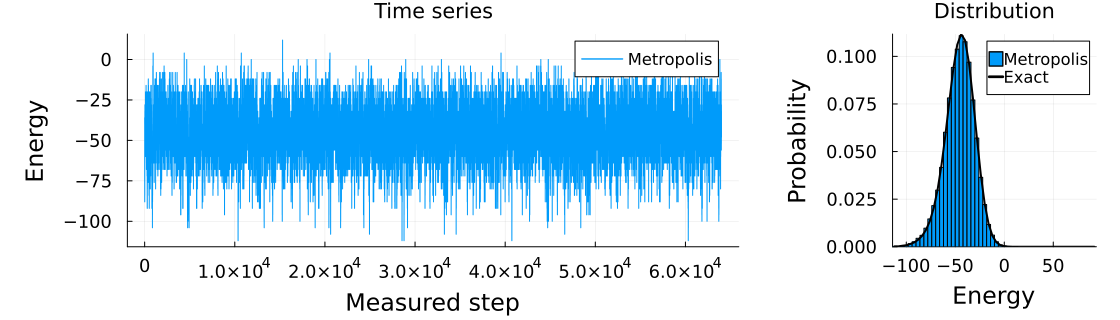

In [9]:
plot_timeseries_distribution(res_meta.energies; label="Metropolis")

## Algorithm 2: HeatBath (optimized 2D only)

In [10]:
sys_hb = IsingLatticeOptim(L, L)
init!(sys_hb, :random, rng=MersenneTwister(seed))
alg_hb = HeatBath(MersenneTwister(seed), β=β)
res_hb = run_chain!(sys_hb, alg_hb; therm_sweeps=therm_sweeps, prod_sweeps=prod_sweeps, interval=measure_interval)

println("HeatBath results (optimized 2D):")
println("  Steps: $(res_hb.steps)")
println("  Average energy per spin: $(round(res_hb.avg_E, digits=4))")
println("  Average magnetization per spin: $(round(res_hb.avg_M, digits=4))")

HeatBath results (optimized 2D):
  Steps: 704000
  Average energy per spin: -0.7179
  Average magnetization per spin: -0.019


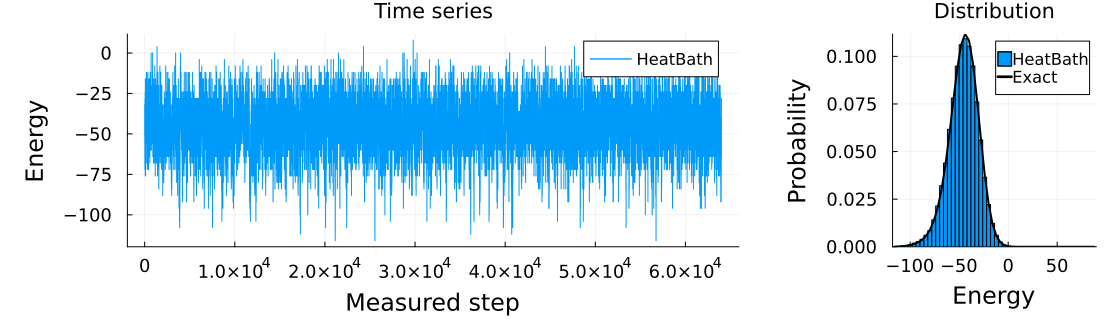

In [11]:
plot_timeseries_distribution(res_hb.energies; label="HeatBath")

## Algorithm 3: Glauber (optimized 2D only)

In [12]:
sys_gla = IsingLatticeOptim(L, L)
init!(sys_gla, :random, rng=MersenneTwister(seed))
alg_gla = Glauber(MersenneTwister(seed), β=β)
res_gla = run_chain!(sys_gla, alg_gla; therm_sweeps=therm_sweeps, prod_sweeps=prod_sweeps, interval=measure_interval)

println("Glauber results (optimized 2D):")
println("  Steps: $(res_gla.steps)")
println("  Acceptance rate: $(round(acceptance_rate(alg_gla), digits=4))")
println("  Average energy per spin: $(round(res_gla.avg_E, digits=4))")
println("  Average magnetization per spin: $(round(res_gla.avg_M, digits=4))")

println("\nAverage energy per spin comparison:")
println("  Metropolis: $(round(res_meta.avg_E, digits=4))")
println("  HeatBath:   $(round(res_hb.avg_E, digits=4))")
println("  Glauber:    $(round(res_gla.avg_E, digits=4))")

Glauber results (optimized 2D):
  Steps: 640000
  Acceptance rate: 0.3369
  Average energy per spin: -0.7101
  Average magnetization per spin: -0.0193

Average energy per spin comparison:
  Metropolis: -0.7153
  HeatBath:   -0.7179
  Glauber:    -0.7101


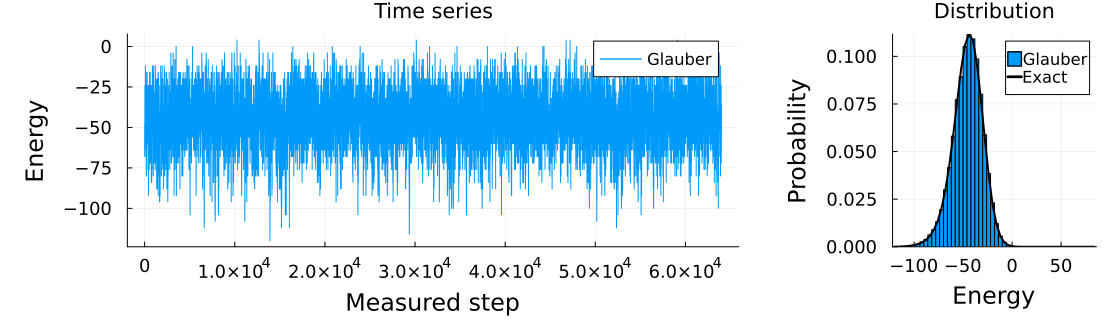

In [13]:
plot_timeseries_distribution(res_gla.energies; label="Glauber")